In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import xgboost as xgb
from imblearn.over_sampling import SMOTE

  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached sklearn_compat-0.1.3-py3-none-any.whl.metadata (18 kB)
  Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl.metadata (15 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
Using cached sklearn_compat-0.1.3-py3-none-any.whl (18 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl (11.1 MB)

  Attempting uninstall: scikit-learn

    Found existing installation: scikit-learn None

   ---------------------------------------- 0/3 [scikit-learn]

Note: you may need to restart the kernel to use updated packages.


error: uninstall-no-record-file

× Cannot uninstall scikit-learn None
╰─> The package's contents are unknown: no RECORD file was found for scikit-learn.

hint: You might be able to recover from this via: pip install --force-reinstall --no-deps scikit-learn==1.7.1


ModuleNotFoundError: No module named 'imblearn'

In [ ]:
data = pd.read_csv('medical_conditions_dataset.csv')

print(data.head())
print(data.info())
print(data.describe())

   id full_name   age gender smoking_status        bmi  blood_pressure  \
0   1  User0001   NaN   male     Non-Smoker        NaN             NaN   
1   2  User0002  30.0   male     Non-Smoker        NaN      105.315064   
2   3  User0003  18.0   male     Non-Smoker  35.612486             NaN   
3   4  User0004   NaN   male     Non-Smoker        NaN       99.119829   
4   5  User0005  76.0   male     Non-Smoker        NaN             NaN   

   glucose_levels  condition  
0             NaN  Pneumonia  
1             NaN   Diabetic  
2             NaN  Pneumonia  
3             NaN  Pneumonia  
4             NaN   Diabetic  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  int64  
 1   full_name       10000 non-null  object 
 2   age             5445 non-null   float64
 3   gender          10000 non-null  

In [ ]:
print(data.isnull().sum())

id                   0
full_name            0
age               4555
gender               0
smoking_status       0
bmi               5348
blood_pressure    6234
glucose_levels    5244
condition            0
dtype: int64


In [ ]:
y = data['condition']
X = data.drop('condition', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
numerical_features = ['id', 'age', 'bmi', 'blood_pressure', 'glucose_levels']
categorical_features = ['full_name', 'gender', 'smoking_status']

In [ ]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [ ]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

# Categorical pipeline: impute then encode
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

In [ ]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))])

In [ ]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='recall_macro',
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__max_depth': [10, 20, ...], 'classifier__min_samples_leaf': [1, 2, ...], 'classifier__n_estimators': [100, 200]}"
,scoring,'recall_macro'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [ ]:
print("Best Hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)
print(f"\nBest cross-validation score (Recall): {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

Best Hyperparameters found by GridSearchCV:
{'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 100}

Best cross-validation score (Recall): 0.3355



Classification Report on Test Data:
              precision    recall  f1-score   support

      Cancer       0.08      0.00      0.01       292
    Diabetic       0.60      0.58      0.59      1203
   Pneumonia       0.25      0.40      0.30       505

    accuracy                           0.45      2000
   macro avg       0.31      0.33      0.30      2000
weighted avg       0.43      0.45      0.43      2000


Confusion Matrix:


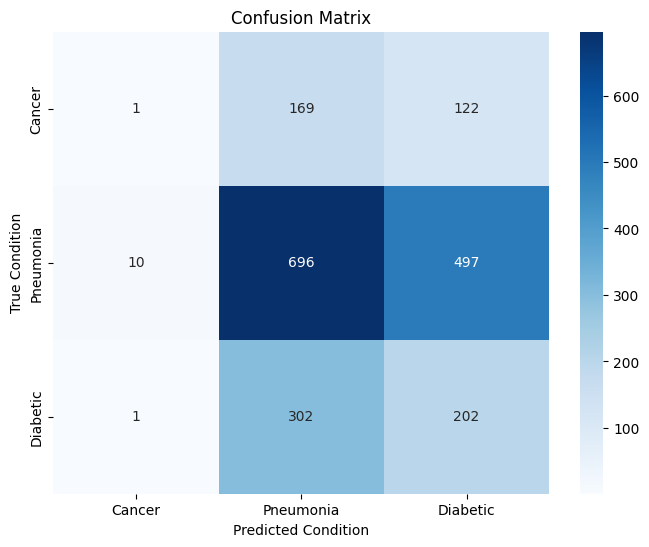

In [ ]:
y_pred = best_model.predict(X_test)


print("\nClassification Report on Test Data:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cancer', 'Pneumonia', 'Diabetic'], 
            yticklabels=['Cancer', 'Pneumonia', 'Diabetic'])
plt.xlabel('Predicted Condition')
plt.ylabel('True Condition')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels as integers for XGBoost
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
])

# 2. Define a parameter grid specific to XGBoost
param_grid_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.7, 1.0]
}

# 3. Run GridSearchCV, optimizing for macro recall
grid_search_xgb = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=param_grid_xgb,
    scoring='recall_macro',
    cv=5,
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train_encoded)

# 4. Analyze the results
print(f"Best cross-validation score (recall_macro): {grid_search_xgb.best_score_:.4f}")
print(f"Best Hyperparameters: {grid_search_xgb.best_params_}")

C:\Users\Joe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [11:52:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best cross-validation score (recall_macro): 0.3342
Best Hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__subsample': 0.7}
